In [ ]:

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 120
SEED = 2


In [ ]:
!pip install pytket-qiskit
!pip install lambeq==0.3.3 # MAKE SURE YOU INSTALL THIS VERSION TO MAKE SURE WE ALL ON THE SAME PAGE :)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 761.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mr_train_data.txt')
dev_labels, dev_data = read_data('datasets/mr_test_data.txt')
test_labels, test_data = read_data('datasets/mr_test_data.txt')

In [ ]:
import os
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1


In [ ]:
from lambeq import BobcatParser, spiders_reader

#parser = BobcatParser(verbose='text')
parser = spiders_reader

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)


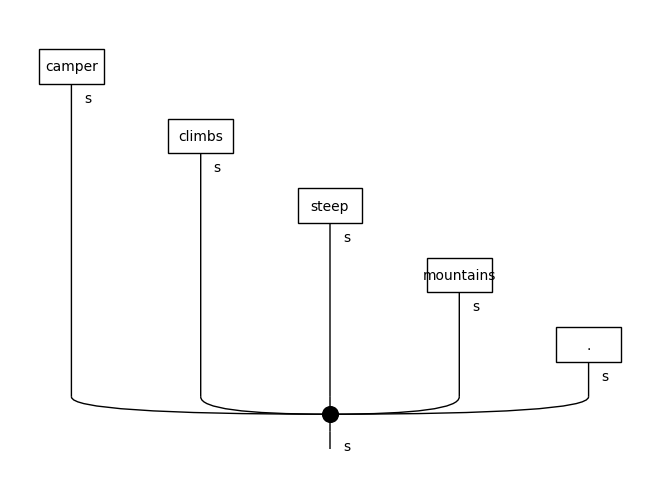

In [ ]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[3].draw()

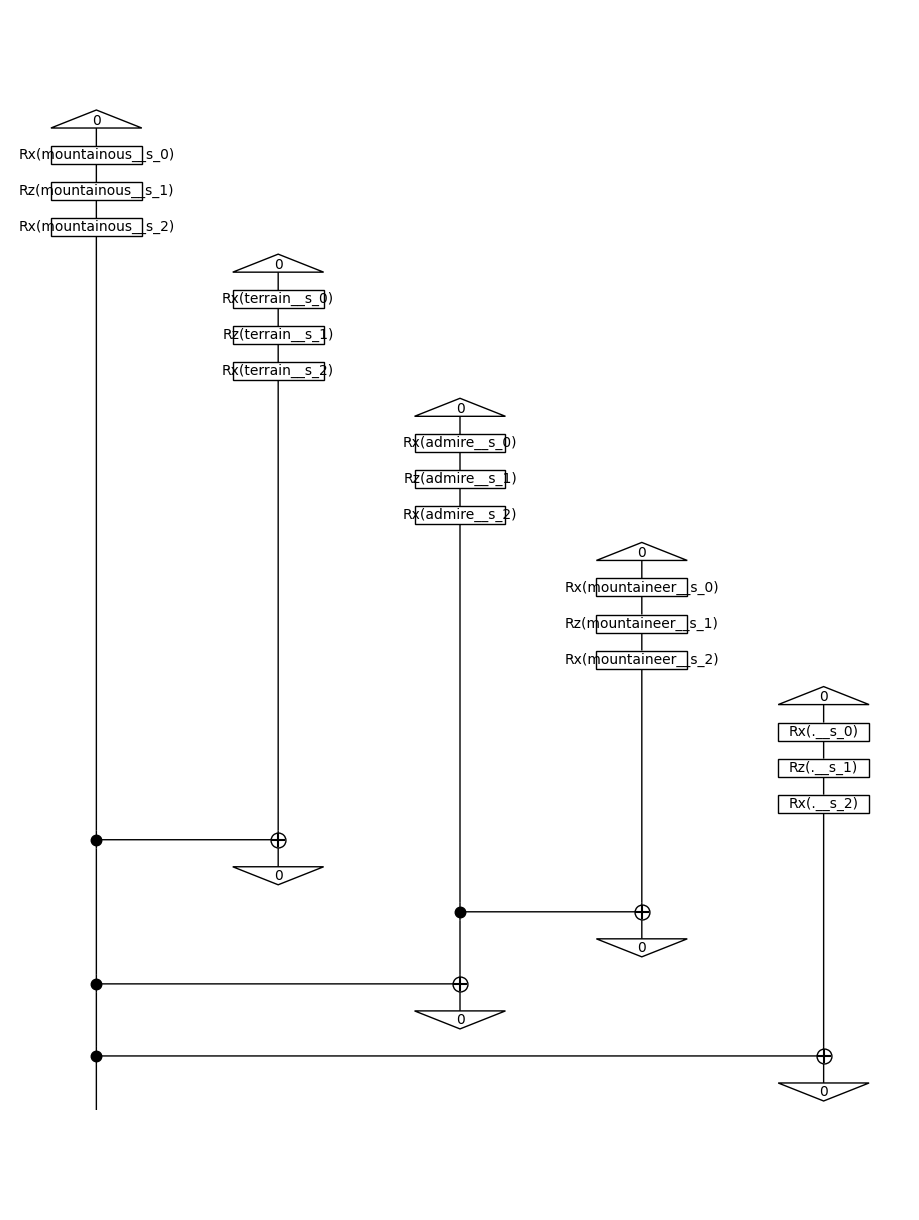

In [ ]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1},
                   n_layers=1, n_single_qubit_params=3,)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

In [ ]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
# model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

# Are you connected to some GPU-enabled runtime? In that case, use JIT models instead!!

from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=False)


In [ ]:

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss(use_jax = False)

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [ ]:
from lambeq import QuantumTrainer, SPSAOptimizer
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


In [ ]:
len(dev_circuits)

18

In [ ]:

from lambeq import Dataset
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=True)

In [ ]:
trainer.fit(train_dataset, val_dataset, log_interval=4)


Epoch 4:    train/loss: 2.4533   valid/loss: 1.1816   train/acc: 0.4429   valid/acc: 0.6667
Epoch 8:    train/loss: 1.5816   valid/loss: 1.5653   train/acc: 0.6571   valid/acc: 0.4444
Epoch 12:   train/loss: 1.2593   valid/loss: 0.6369   train/acc: 0.7143   valid/acc: 0.7778
Epoch 16:   train/loss: 0.3464   valid/loss: 0.4895   train/acc: 0.6857   valid/acc: 0.7778
Epoch 20:   train/loss: 0.6778   valid/loss: 0.6441   train/acc: 0.7714   valid/acc: 0.7222
Epoch 24:   train/loss: 0.5752   valid/loss: 0.7127   train/acc: 0.8857   valid/acc: 0.6667
Epoch 28:   train/loss: 0.1009   valid/loss: 0.6541   train/acc: 0.8714   valid/acc: 0.7778
Exception ignored in: <function _xla_gc_callback at 0x7c848e8a2680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Epoch 32:   train/loss: 0.1743   valid/loss: 0.3437   train/acc: 0.9000   valid/acc: 0.8889
Exc

KeyboardInterrupt: ignored

In [ ]:
filename = 'finalized_model_more_accurate.lt'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
model.save('mr_model_more_accurate.lt')

Test accuracy: 0.8333333333333334


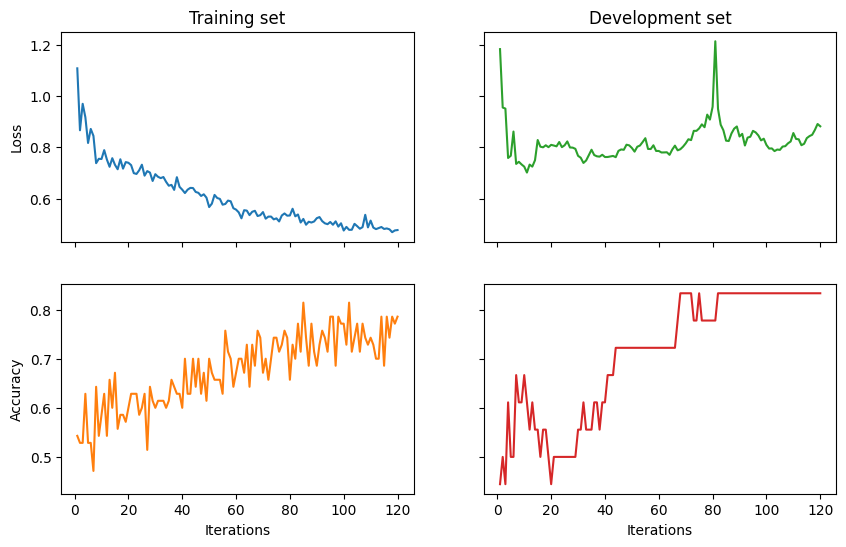

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs +1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)

In [ ]:
test_acc /= acc(model(test_circuits), np.array(test_labels))

In [ ]:
print(test_acc)

1.0


In [ ]:
model(test_circuits[:5])



array([[0.52911908, 0.47088092],
       [0.43530207, 0.56469793],
       [0.19052919, 0.80947081],
       [0.66089759, 0.33910241],
       [0.88856585, 0.11143415]])

In [ ]:
print(test_labels)

[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]


In [ ]:
model([test_circuits[2]])

array([[0.19052919, 0.80947081]])

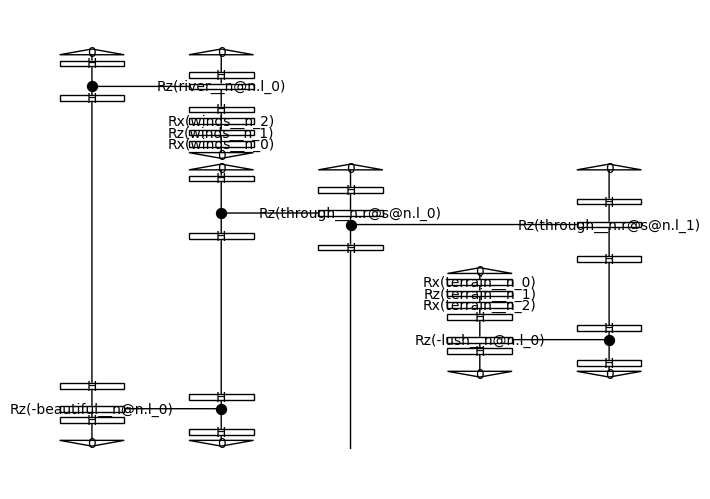

In [ ]:
test_circuits[2].draw()

In [ ]:
model.weights
print(diagram)
import tensornetwork as tn
lamdaified = model._get_lambda(circuit)

print(lamdaified)
print(tn.contractors)

lamdaified(model.weights)

NameError: ignored

In [ ]:

from collections.abc import Callable, Iterable
import pickle
from typing import Any, TYPE_CHECKING

import discopy
from discopy.tensor import Diagram
import numpy
from numpy.typing import ArrayLike
from sympy import lambdify


def _fast_subs(self,
                   diagrams: list[Diagram],
                   weights: Iterable[ArrayLike]) -> list[Diagram]:
        """Substitute weights into a list of parameterised circuit."""
        parameters = {k: v for k, v in zip(self.symbols, weights)}
        diagrams = pickle.loads(pickle.dumps(diagrams))  # does fast deepcopy
        for diagram in diagrams:
            for b in diagram.boxes:
                if b.free_symbols:
                    while hasattr(b, 'controlled'):
                        b = b.controlled
                    syms, values = [], []
                    for sym in b.free_symbols:
                        syms.append(sym)
                        try:
                            values.append(parameters[sym])
                        except KeyError as e:
                            raise KeyError(
                                f'Unknown symbol: {repr(sym)}'
                            ) from e
                    b.data = lambdify(syms, b.data)(*values)
                    b.drawing_name = b.name
                    del b.free_symbols
        return diagrams

In [ ]:
circuit_2 = model._fast_subs([test_circuits[2]], model.weights)[0]
from pytket.circuit.display import render_circuit_jupyter
tket_circuit = circuit_2.to_tk()
render_circuit_jupyter(tket_circuit)

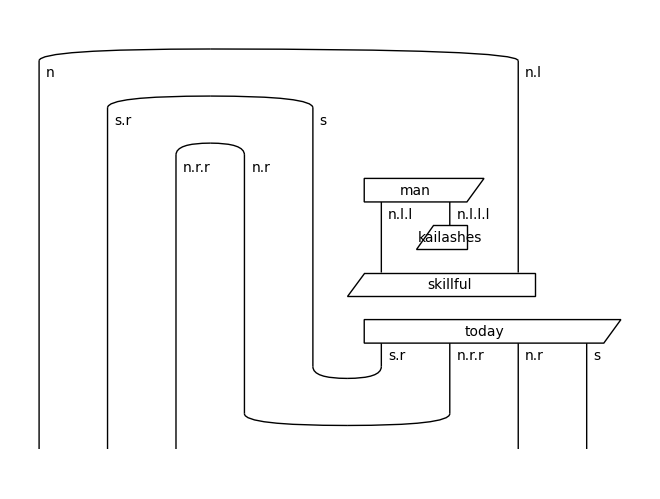

KeyError: ignored

In [ ]:
sentence = "skillful man kailashes today"

diagram = parser.sentence2diagram(sentence)

diagram = remove_cups(diagram)
diagram.draw()
circuit = ansatz(diagram)

model([circuit])

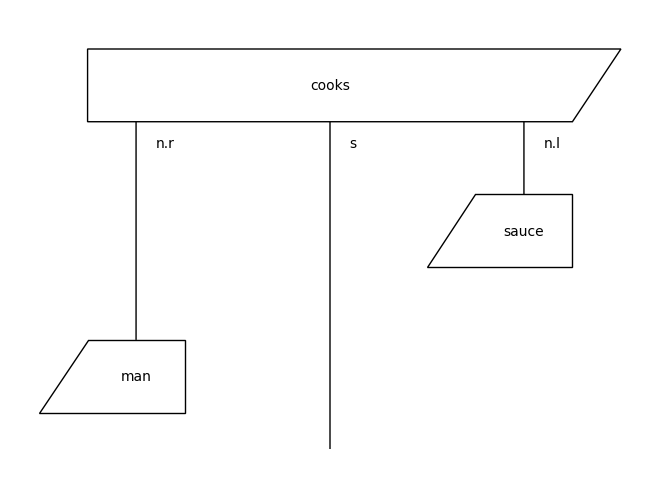

Array([[0.89528275, 0.10471724]], dtype=float32)

In [ ]:
bsentence = "he cooks food"

diagram = parser.sentence2diagram(sentence)

diagram = remove_cups(diagram)
diagram.draw()


circuit = ansatz(diagram)

model([circuit])


In [ ]:
print(model)

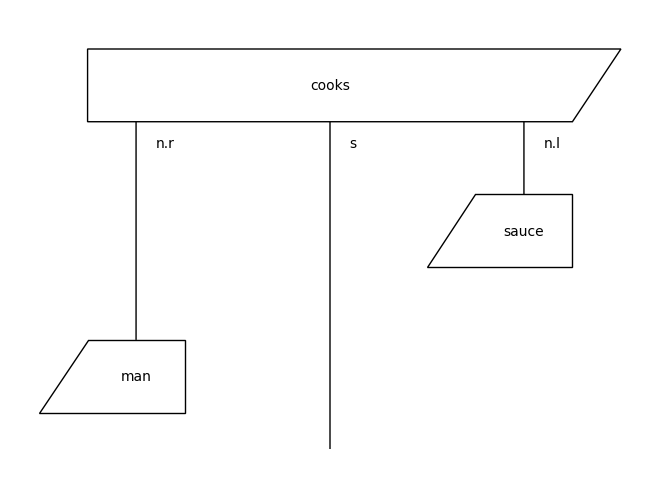

Array([[0.89528275, 0.10471724]], dtype=float32)

In [ ]:
bsentence = "man cooks sauce"

diagram = parser.sentence2diagram(sentence)

diagram = remove_cups(diagram)
diagram.draw()


man_circuit = ansatz(diagram)

model([circuit])

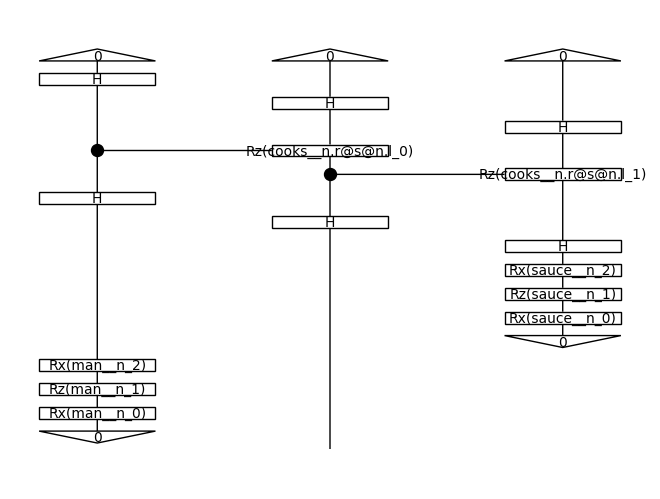

In [ ]:
circuit.draw()

In [ ]:
circuit_3 = model._fast_subs([man_circuit], model.weights)[0]
from pytket.circuit.display import render_circuit_jupyter
tket3_circuit = circuit_3.to_tk()
render_circuit_jupyter(tket3_circuit)

NameError: ignored

In [ ]:
model.symbols

[active__n@n.l_0,
 admire__n.r@s@n.l_0,
 admire__n.r@s@n.l_1,
 admires__n.r@s@n.l_0,
 admires__n.r@s@n.l_1,
 adventurer.__n_0,
 adventurer.__n_1,
 adventurer.__n_2,
 adventurer__n@n.l_0,
 adventurer__n_0,
 adventurer__n_1,
 adventurer__n_2,
 adventurous__n@n.l_0,
 ascends__n.r@s@n.l_0,
 ascends__n.r@s@n.l_1,
 at__s.r@n.r.r@n.r@s@n.l_0,
 at__s.r@n.r.r@n.r@s@n.l_1,
 at__s.r@n.r.r@n.r@s@n.l_2,
 at__s.r@n.r.r@n.r@s@n.l_3,
 awaits__n.r@s@n.l_0,
 awaits__n.r@s@n.l_1,
 awes__n.r@s@n.l_0,
 awes__n.r@s@n.l_1,
 beautiful__n@n.l_0,
 beauty__n_0,
 beauty__n_1,
 beauty__n_2,
 boats__n.r@s@n.l_0,
 boats__n.r@s@n.l_1,
 boats__n_0,
 boats__n_1,
 boats__n_2,
 breath-taking__n@n.l_0,
 breathtaking__n@n.l_0,
 camp__n_0,
 camp__n_1,
 camp__n_2,
 camper__n_0,
 camper__n_1,
 camper__n_2,
 carves__n.r@s@n.l_0,
 carves__n.r@s@n.l_1,
 challenge__n.r@s@n.l_0,
 challenge__n.r@s@n.l_1,
 challenge__n_0,
 challenge__n_1,
 challenge__n_2,
 challenges__n.r@s@n.l_0,
 challenges__n.r@s@n.l_1,
 chill__n@n.l_0,
 clear__n

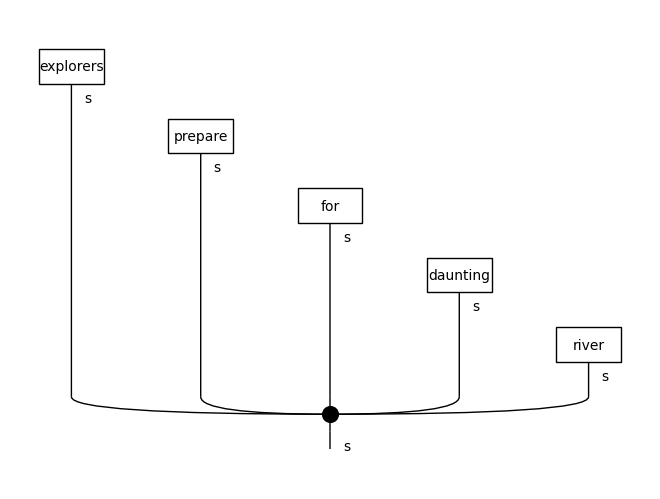

array([[0.99360724, 0.00639276]])

In [ ]:
csentence = "explorers prepare for daunting river"

cdiagram = parser.sentence2diagram(csentence)

cdiagram = remove_cups(cdiagram)
cdiagram.draw()


man2_circuit = ansatz(cdiagram)

model([man2_circuit])

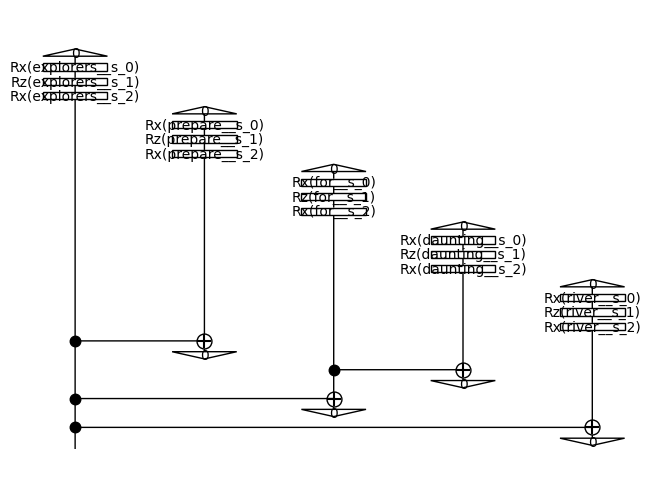

In [ ]:
man2_circuit.draw()

In [ ]:
circuit_4 = model._fast_subs([man2_circuit], model.weights)[0]
from pytket.circuit.display import render_circuit_jupyter
tket4_circuit = circuit_4.to_tk()
render_circuit_jupyter(tket4_circuit)

In [ ]:
!pip install frozenmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [ ]:
# Sentence generation

from nltk import CFG
from nltk.parse.generate import generate



sentence_map = {}
def _create_sentence_search_space(n = 10000):
    MC_GRAMMAR = """
      S -> NP VP
      NP -> N
      VP -> V NP
      NP -> A N
      A -> 'lush' | 'beautiful' | 'serene' | 'scenic' | 'fresh' | 'cool' |
      N -> 'mountains' | 'rivers' | 'season' | 'rock' | 'water' | 'snow' | 'valley' | 'forest'
      V -> 'explore' | 'climb' | 'melt' | 'erode' | 'meet' | 'surround' | 'form' | 'run'
      """

    VOCAB = ["mountains", "rivers", "explore", "season", "rock", "water", "flow", "snow", "climb", "valley", "hike", "swim", "lush", "beautiful", "serene", "forest", "range", "scenic", "landscape", "peak", "tributaries", "steep", "trail", "glacier", "ice", "sky", "summit", "slopes", "bank", "terrain", "fresh", "cool", "view", "spectacular", "camp", "steep", "slope", "lights", "tops", "outlet", "melt", "erode", "meet", "mountainous", "layer", "valley", "surround", "form", "riverbed", "run", "scale", "follow", "rise", "reflect", "descend", "run", "creates", "admire", "witness", "host", "stream", "witness", "lovely", "vast", "tranquil", "towering", "rolling", "rocky", "snaking", "gushing", "snow-capped", "clear", "rapid", "stunning", "rugged", "breathtaking", "tranquil", "scenic", "shimmering", "winding", "cascading", "peak", "hiker", "trekker", "camper", "mountaineer", "adventurer", "explorer", "rafter", "hiker", "fisherman", "traveler", "flows"]

    subjects = ['mountains', 'rivers', 'season', 'rock', 'water', 'snow', 'valley', 'forest', 'range', 'landscape', 'peak', 'tributaries', 'trail', 'glacier', 'ice', 'sky', 'summit', 'slopes', 'bank', 'terrain', 'view', 'camp', 'slope', 'lights', 'tops', 'outlet', 'mountains', 'layer', 'valley', 'riverbed', 'mountaineer', 'adventurer', 'explorer', 'rafter', 'hiker', 'fisherman', 'traveler', 'hike', 'swim', 'flow', 'stream']
    objects = ['mountains', 'rivers', 'season', 'rock', 'water', 'snow', 'valley', 'forest', 'range', 'landscape', 'peak', 'tributaries', 'trail', 'glacier', 'ice', 'sky', 'summit', 'slopes', 'bank', 'terrain', 'view', 'camp', 'slope', 'lights', 'tops', 'outlet', 'mountains', 'layer', 'valley', 'riverbed', 'mountaineer', 'adventurer', 'explorer', 'rafter', 'hiker', 'fisherman', 'traveler', 'hike', 'swim', 'flow', 'stream']


    GRAMMAR = CFG.fromstring(MC_GRAMMAR)
    SENTENCES = list(generate(GRAMMAR, n = n))

    def filter_sentence(sentence):
        # Make sure no word appears more than once:
        if not len(set(sentence)) == len(sentence):
            return False

        # Make sure subject appears before object:
        # try:
        #     subject_position = next(i for i,v in enumerate(sentence) if v in subjects)
        #     object_position = next(i for i,v in enumerate(sentence) if v in objects)
        # except:
        #     return False
        #return subject_position < object_position
        return True

    SENTENCES = list(filter(filter_sentence, SENTENCES))
    return SENTENCES


def create_adjacency_list(sentences):
    adjacency_list = {tuple(sentence): [] for sentence in sentences}

    for i, sentence1 in enumerate(sentences):
        for j, sentence2 in enumerate(sentences):
            if i != j and is_array_edit_distance_equal_to_1(sentence1, sentence2):
                adjacency_list[tuple(sentence1)].append(sentence2)

    return adjacency_list

def sentence_diff(s1, s2):
  return is_array_edit_distance_equal_to_1(s1, s2)


def array_edit_distance(arr1, arr2):
    m, n = len(arr1), len(arr2)

    # Create a matrix to store the dynamic programming results
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the matrix with the distances for empty arrays
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Fill in the matrix using the Wagner-Fisher algorithm
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if arr1[i - 1] == arr2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,      # Deletion
                           dp[i][j - 1] + 1,      # Insertion
                           dp[i - 1][j - 1] + cost)  # Substitution

    # Return the final array-level edit distance
    return dp[m][n]

def is_array_edit_distance_equal_to_1(arr1, arr2):
    # Check if the array-level edit distance is equal to 1
    return array_edit_distance(arr1, arr2) == 1


def _measure_quantum_circuit_for_sentence(sentence):
    diagram = parser.sentences2diagrams([sentence])

    circ = [ansatz(d) for d in diagram]

    return model.get_diagram_output(circ)[0]

In [ ]:
import collections

# got this from some random stack overflow post but idt i actually need it
class FrozenDict(collections.abc.Mapping):
    """Don't forget the docstrings!!"""

    def __init__(self, *args, **kwargs):
        self._d = dict(*args, **kwargs)
        self._hash = None

    def __iter__(self):
        return iter(self._d)

    def __len__(self):
        return len(self._d)

    def __getitem__(self, key):
        return self._d[key]

    def __hash__(self):
        # It would have been simpler and maybe more obvious to
        # use hash(tuple(sorted(self._d.iteritems()))) from this discussion
        # so far, but this solution is O(n). I don't know what kind of
        # n we are going to run into, but sometimes it's hard to resist the
        # urge to optimize when it will gain improved algorithmic performance.
        if self._hash is None:
            hash_ = 0
            for pair in self.items():
                hash_ ^= hash(pair)
            self._hash = hash_
        return self._hash

In [ ]:
|sentence1 = ['tasty', 'woman', 'runs', 'skillful', 'software']
sentence2 = ['boop', 'hi', 'runs', 'skillful', 'software']


print(is_array_edit_distance_equal_to_1(sentence1, sentence2))

SyntaxError: ignored

In [ ]:
import random
SENTENCES = _create_sentence_search_space()
sentence_map = create_adjacency_list(SENTENCES)

KeyboardInterrupt: ignored

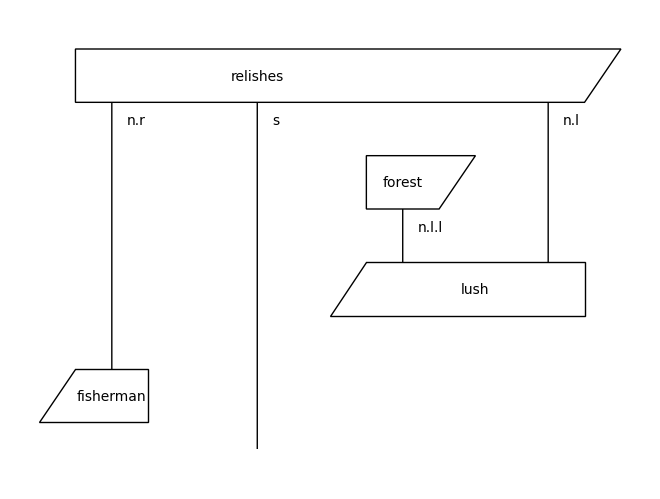

array([[0.18578336, 0.81421664]])

In [ ]:
bsentence = "fisherman relishes lush forest"

diagram = parser.sentence2diagram(bsentence)

diagram = remove_cups(diagram)
diagram.draw()


circuit = ansatz(diagram)

model([circuit])

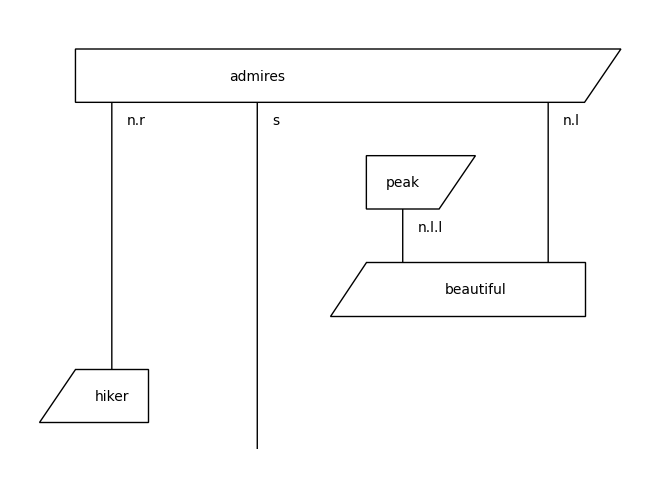

array([[0.78891682, 0.21108318]])

In [ ]:
csentence = "hiker admires beautiful peak"

diagram = parser.sentence2diagram(csentence)

diagram = remove_cups(diagram)
diagram.draw()


circuit = ansatz(diagram)

model([circuit])

In [ ]:
print(sentence_map)

{}


In [ ]:
import random

# Food or IT
# keeps randomly generating sentences & takes sentence if classifier confidence > threshold (0.9)

# generate_sentence(topic, T)
# 1. Randomly generate sentence
# 2. Check confidence threshold (is p > 0.9)
# 3. if it's not, replace one of the words in the sentence.
# 4. check confidence threshold (is new p > old p), and if so, we want to commit that change
# 5. f(T) > threshold: even if confidence threshold is NOT increased by the change, we still commit the change
# 6. run for many iterations


# Simulated annealing, metropolis-hastings
def randomly_generate_sentence_with_topic(topic, T):
    i = 0
    current_sentence = random.choice(SENTENCES)
    print(current_sentence)
    current_prediction = _measure_quantum_circuit_for_sentence(" ".join(current_sentence))

    while i < 100:
        i += 1
        print(i)
        new_sentence = random.choice(sentence_map[tuple(current_sentence)])
        print(new_sentence)
        new_prediction = _measure_quantum_circuit_for_sentence(" ".join(new_sentence))
        # At each timestep, choose one word to replace


        print(new_prediction)
        relevant_index = 1 if topic == "IT" else 0
        if current_prediction[relevant_index] > 0.7:
          return i, current_prediction
          break
        if new_prediction[relevant_index] > 0.7:
          return i, new_sentence
          break
        acceptance_P = np.exp(-(new_prediction[relevant_index] - current_prediction[relevant_index])/T)
        random_dude = random.random()

        if new_prediction[relevant_index] > current_prediction[relevant_index] and random_dude < acceptance_P:
          current_sentence = new_sentence
          current_prediction = new_prediction

    return 100, "Max iterations reached"

In [ ]:
randomly_generate_sentence_with_topic("IT", 0)

['snow', 'run', 'lush', 'water']


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


KeyError: ignored

In [ ]:
import random

# Food or IT
# keeps randomly generating sentences & takes sentence if classifier confidence > threshold (0.9)

# generate_sentence(topic, T)
# 1. Randomly generate sentence
# 2. Check confidence threshold (is p > 0.9)
# 3. if it's not, replace one of the words in the sentence.
# 4. check confidence threshold (is new p > old p), and if so, we want to commit that change
# 5. f(T) > threshold: even if confidence threshold is NOT increased by the change, we still commit the change
# 6. run for many iterations


# Simulated annealing, metropolis-hastings
def randomly_generate_sentence_with_topic(topic, T):
    i = 0
    current_sentence = random.choice(SENTENCES)
    print(current_sentence)
    current_prediction = _measure_quantum_circuit_for_sentence(" ".join(current_sentence))

    while i < 100:
        i += 1
        print(i)
        new_sentence = random.choice(sentence_map[tuple(current_sentence)])
        print(new_sentence)
        new_prediction = _measure_quantum_circuit_for_sentence(" ".join(new_sentence))
        # At each timestep, choose one word to replace


        print(new_prediction)
        relevant_index = 1 if topic == "IT" else 0
        if current_prediction[relevant_index] > 0.9:
          return i, current_prediction
          break
        if new_prediction[relevant_index] > 0.9:
          return i, new_sentence
          break
        acceptance_P = np.exp(-(new_prediction[relevant_index] - current_prediction[relevant_index])/T)
        random_dude = random.random()

        if new_prediction[relevant_index] > current_prediction[relevant_index] and random_dude < acceptance_P:
          current_sentence = new_sentence
          current_prediction = new_prediction

    return 100, "Max iterations reached"

In [ ]:
randomly_generate_sentence_with_topic("IT", 1)


['lush', 'valley', 'run', 'water']


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


KeyError: ignored